## Evaluates the circulation budget for ERA5 data

See `budgets.py` for the actual code used to calculate the budget terms. There are both area-integral and line-integral forms, which produce very similar results. 

### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.patches import Polygon
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, LocalCluster, Scheduler
import sys

# import files from local directory
sys.path.append('/home/565/cr7888/share_code/circulation_budget/')
from budgets import *

### Setup dask cluster

In [2]:
try:
    client
except:
    cluster = LocalCluster()
    client = Client(cluster)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44547 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44547/status,
Dashboard: /proxy/44547/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35227,Workers: 7
Dashboard: /proxy/44547/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:34683,Total threads: 1
Dashboard: /proxy/44761/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:46551,


### Constants

### Setup options

In [3]:
# Pressure levels to average over (column_integrate is True)
min_p = 100
max_p = 1000

# single pressure level to plot (column_integrate is False)
# note that this must lie inbetween min_p and max_p since we need vertical derivatives to calculate the tilting term.
p = 700

column_integrate = False

# box to evaluate the budget over
min_lon_A, max_lon_A = 134, 142
min_lat_A, max_lat_A = 12, 20

min_lon_B, max_lon_B = 114, 122
min_lat_B, max_lat_B = 10, 18

min_lon_C, max_lon_C = 110, 118
min_lat_C, max_lat_C = 25, 33

min_lon_D, max_lon_D = 144, 152
min_lat_D, max_lat_D = 25, 33

# start and end times of the budget
start_time, end_time = '2016-07-01T13:00:00', '2016-07-06T12:00:00' # start of Jul 2 to end of Jul 5

# create list of dates to open
date_list = pd.date_range(start_time, end_time)
year = date_list.year[0]

# path to era5 data
era5_path = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# path to parameterised tendency data
u_tend_path = '/scratch/k10/cr7888/budget_fran/u_param_tend_plev_2016_fran.nc' 
v_tend_path = '/scratch/k10/cr7888/budget_fran/v_param_tend_plev_2016_fran.nc'

### Load data

In [4]:
%%time
%%capture --no-stdout

# Open and subset data

u = xr.open_mfdataset(era5_path+f'u/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['u']
v = xr.open_mfdataset(era5_path+f'v/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['v']
w = xr.open_mfdataset(era5_path+f'w/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['w']
rv = xr.open_mfdataset(era5_path+f'vo/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['vo']

u_A = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))
v_A = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))
w_A = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))
rv_A = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))

u_B = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))
v_B = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))
w_B = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))
rv_B = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))

u_C = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))
v_C = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))
w_C = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))
rv_C = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))

u_D = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))
v_D = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))
w_D = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))
rv_D = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))

0.3.0
CPU times: user 6.15 s, sys: 2.74 s, total: 8.89 s
Wall time: 11.4 s


In [5]:
%%time

# this is the friction/subgrid wind tendencies

def get_fric_area(u_tend, v_tend, min_lon, max_lon, min_lat, max_lat):

    u_tend = u_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))
    v_tend = v_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))

    u_tend = u_tend.rename({'pressure': 'level'})
    v_tend = v_tend.rename({'pressure': 'level'})

    u_tend['level'] = u_tend['level'] / 100
    v_tend['level'] = v_tend['level'] / 100

    # fill nan values (e.g. below the surface) with 0.
    # should be okay since there are no parameterisations below the surface!
    u_tend = u_tend.fillna(0)
    v_tend = v_tend.fillna(0)
    
    return u_tend, v_tend

u_tend = xr.open_dataarray(u_tend_path, chunks={'time': 24, 'pressure': 10})
v_tend = xr.open_dataarray(v_tend_path, chunks={'time': 24, 'pressure': 10})

u_tend_A, v_tend_A = get_fric_area(u_tend, v_tend, min_lon_A, max_lon_A, min_lat_A, max_lat_A)
u_tend_B, v_tend_B = get_fric_area(u_tend, v_tend, min_lon_B, max_lon_B, min_lat_B, max_lat_B)
u_tend_C, v_tend_C = get_fric_area(u_tend, v_tend, min_lon_C, max_lon_C, min_lat_C, max_lat_C)
u_tend_D, v_tend_D = get_fric_area(u_tend, v_tend, min_lon_D, max_lon_D, min_lat_D, max_lat_D)


CPU times: user 68.7 ms, sys: 19.2 ms, total: 87.9 ms
Wall time: 78.8 ms


Loading the data into memory now can make the following code much faster (assuming it's not too big) -- this may take some time

In [6]:
%%time
u_A = u_A.compute()
v_A = v_A.compute()
w_A = w_A.compute()
rv_A = rv_A.compute()
u_tend_A = u_tend_A.compute()
v_tend_A = v_tend_A.compute()

u_B = u_B.compute()
v_B = v_B.compute()
w_B = w_B.compute()
rv_B = rv_B.compute()
u_tend_B = u_tend_B.compute()
v_tend_B = v_tend_B.compute()

u_C = u_C.compute()
v_C = v_C.compute()
w_C = w_C.compute()
rv_C = rv_C.compute()
u_tend_C = u_tend_C.compute()
v_tend_C = v_tend_C.compute()

u_D = u_D.compute()
v_D = v_D.compute()
w_D = w_D.compute()
rv_D = rv_D.compute()
u_tend_D = u_tend_D.compute()
v_tend_D = v_tend_D.compute()

CPU times: user 5.01 s, sys: 765 ms, total: 5.78 s
Wall time: 15.7 s


### Perform the budget calculation (as a time series)

The code to do this is in `budgets.py`. There are different versions depending on whether or not we include friction. There are also line-integral versions of the code (here we just use area integrals, both are very similar)

In [7]:
%%time

dav_dt_A, flux_div_A, div_A, adv_A, tilt_A, res_A, fric_A, res_fric_A = circulation_budget(
    u_A, v_A, w_A, rv_A, calc_fric=True, u_param=u_tend_A, v_param=v_tend_A, column_integrate=column_integrate)
dav_dt_A, flux_div_A, div_A, adv_A, tilt_A, res_A, fric_A, res_fric_A = dask.compute(dav_dt_A, flux_div_A, div_A, adv_A, tilt_A, res_A, fric_A, res_fric_A)

dav_dt_B, flux_div_B, div_B, adv_B, tilt_B, res_B, fric_B, res_fric_B = circulation_budget(
    u_B, v_B, w_B, rv_B, calc_fric=True, u_param=u_tend_B, v_param=v_tend_B, column_integrate=column_integrate)
dav_dt_B, flux_div_B, div_B, adv_B, tilt_B, res_B, fric_B, res_fric_B = dask.compute(dav_dt_B, flux_div_B, div_B, adv_B, tilt_B, res_B, fric_B, res_fric_B)

dav_dt_C, flux_div_C, div_C, adv_C, tilt_C, res_C, fric_C, res_fric_C = circulation_budget(
    u_C, v_C, w_C, rv_C, calc_fric=True, u_param=u_tend_C, v_param=v_tend_C, column_integrate=column_integrate)
dav_dt_C, flux_div_C, div_C, adv_C, tilt_C, res_C, fric_C, res_fric_C = dask.compute(dav_dt_C, flux_div_C, div_C, adv_C, tilt_C, res_C, fric_C, res_fric_C)

dav_dt_D, flux_div_D, div_D, adv_D, tilt_D, res_D, fric_D, res_fric_D = circulation_budget(
    u_D, v_D, w_D, rv_D, calc_fric=True, u_param=u_tend_D, v_param=v_tend_D, column_integrate=column_integrate)
dav_dt_D, flux_div_D, div_D, adv_D, tilt_D, res_D, fric_D, res_fric_D = dask.compute(dav_dt_D, flux_div_D, div_D, adv_D, tilt_D, res_D, fric_D, res_fric_D)

CPU times: user 3.21 s, sys: 329 ms, total: 3.54 s
Wall time: 3.27 s


In [8]:
# using line integrals instead
Z_x_A, Z_y_A, adv_x_A, adv_y_A, tilt_x_A, tilt_y_A, fric_x_A, fric_y_A = absolute_vorticity_flux(u_A, v_A, w_A, rv_A, calc_fric=True, u_param=u_tend_A, v_param=v_tend_A)
Z_x_B, Z_y_B, adv_x_B, adv_y_B, tilt_x_B, tilt_y_B, fric_x_B, fric_y_B = absolute_vorticity_flux(u_B, v_B, w_B, rv_B, calc_fric=True, u_param=u_tend_B, v_param=v_tend_B)
Z_x_C, Z_y_C, adv_x_C, adv_y_C, tilt_x_C, tilt_y_C, fric_x_C, fric_y_C = absolute_vorticity_flux(u_C, v_C, w_C, rv_C, calc_fric=True, u_param=u_tend_C, v_param=v_tend_C)
Z_x_D, Z_y_D, adv_x_D, adv_y_D, tilt_x_D, tilt_y_D, fric_x_D, fric_y_D = absolute_vorticity_flux(u_D, v_D, w_D, rv_D, calc_fric=True, u_param=u_tend_D, v_param=v_tend_D)

flux_total_A, flux_south_A, flux_east_A, flux_north_A, flux_west_A = boundary_flux(Z_x_A, Z_y_A)
adv_total_A, adv_south_A, adv_east_A, adv_north_A, adv_west_A = boundary_flux(adv_x_A, adv_y_A)
tilt_total_A, tilt_south_A, tilt_east_A, tilt_north_A, tilt_west_A = boundary_flux(tilt_x_A, tilt_y_A)
fric_total_A, fric_south_A, fric_east_A, fric_north_A, fric_west_A = boundary_flux(fric_x_A, fric_y_A)

flux_total_B, flux_south_B, flux_east_B, flux_north_B, flux_west_B = boundary_flux(Z_x_B, Z_y_B)
adv_total_B, adv_south_B, adv_east_B, adv_north_B, adv_west_B = boundary_flux(adv_x_B, adv_y_B)
tilt_total_B, tilt_south_B, tilt_east_B, tilt_north_B, tilt_west_B = boundary_flux(tilt_x_B, tilt_y_B)
fric_total_B, fric_south_B, fric_east_B, fric_north_B, fric_west_B = boundary_flux(fric_x_B, fric_y_B)

flux_total_C, flux_south_C, flux_east_C, flux_north_C, flux_west_C = boundary_flux(Z_x_C, Z_y_C)
adv_total_C, adv_south_C, adv_east_C, adv_north_C, adv_west_C = boundary_flux(adv_x_C, adv_y_C)
tilt_total_C, tilt_south_C, tilt_east_C, tilt_north_C, tilt_west_C = boundary_flux(tilt_x_C, tilt_y_C)
fric_total_C, fric_south_C, fric_east_C, fric_north_C, fric_west_C = boundary_flux(fric_x_C, fric_y_C)

flux_total_D, flux_south_D, flux_east_D, flux_north_D, flux_west_D = boundary_flux(Z_x_D, Z_y_D)
adv_total_D, adv_south_D, adv_east_D, adv_north_D, adv_west_D = boundary_flux(adv_x_D, adv_y_D)
tilt_total_D, tilt_south_D, tilt_east_D, tilt_north_D, tilt_west_D = boundary_flux(tilt_x_D, tilt_y_D)
fric_total_D, fric_south_D, fric_east_D, fric_north_D, fric_west_D = boundary_flux(fric_x_D, fric_y_D)

In [9]:
res_fric_total_A = dav_dt_A - flux_total_A
res_fric_total_B = dav_dt_B - flux_total_B
res_fric_total_C = dav_dt_C - flux_total_C
res_fric_total_D = dav_dt_D - flux_total_D

res_total_A = dav_dt_A - adv_total_A - tilt_total_A
res_total_B = dav_dt_B - adv_total_B - tilt_total_B
res_total_C = dav_dt_C - adv_total_C - tilt_total_C
res_total_D = dav_dt_D - adv_total_D - tilt_total_D

Take a 24-hour moving average to remove the diurnal cycle (often makes the time series look very messy, especially over land)

In [10]:
n_av = 24

dav_dt_smooth_A = moving_average(dav_dt_A, n=n_av)
flux_div_smooth_A = moving_average(adv_total_A, n=n_av)
tilt_smooth_A = moving_average(tilt_total_A, n=n_av)
res_smooth_A = moving_average(res_total_A, n=n_av)
fric_smooth_A = moving_average(fric_total_A, n=n_av)
res_fric_smooth_A = moving_average(res_fric_total_A, n=n_av)

dav_dt_smooth_B = moving_average(dav_dt_B, n=n_av)
flux_div_smooth_B = moving_average(adv_total_B, n=n_av)
tilt_smooth_B = moving_average(tilt_total_B, n=n_av)
res_smooth_B = moving_average(res_total_B, n=n_av)
fric_smooth_B = moving_average(fric_total_B, n=n_av)
res_fric_smooth_B = moving_average(res_fric_total_B, n=n_av)

dav_dt_smooth_C = moving_average(dav_dt_C, n=n_av)
flux_div_smooth_C = moving_average(adv_total_C, n=n_av)
tilt_smooth_C = moving_average(tilt_total_C, n=n_av)
res_smooth_C = moving_average(res_total_C, n=n_av)
fric_smooth_C = moving_average(fric_total_C, n=n_av)
res_fric_smooth_C = moving_average(res_fric_total_C, n=n_av)

dav_dt_smooth_D = moving_average(dav_dt_D, n=n_av)
flux_div_smooth_D = moving_average(adv_total_D, n=n_av)
tilt_smooth_D = moving_average(tilt_total_D, n=n_av)
res_smooth_D = moving_average(res_total_D, n=n_av)
fric_smooth_D = moving_average(fric_total_D, n=n_av)
res_fric_smooth_D = moving_average(res_fric_total_D, n=n_av)

### Budget cross-sections at a single time

We load the data again since we need multiple pressure levels. The same calculations are performed as before.

In [11]:
%%time
%%capture --no-stdout

cs_start_time, cs_end_time = '2016-07-05T00:00', '2016-07-05T02:00' # need 3 time steps to get d/dt
# cs_time = '2016-07-05T01:00'

# Open and subset data

u_cs = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/u/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['u']
v_cs = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/v/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['v']
w_cs = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/w/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['w']
rv_cs = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/vo/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['vo']

u_cs_A = u_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A)).compute()
v_cs_A = v_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A)).compute()
w_cs_A = w_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A)).compute()
rv_cs_A = rv_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A)).compute()

u_cs_B = u_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B)).compute()
v_cs_B = v_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B)).compute()
w_cs_B = w_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B)).compute()
rv_cs_B = rv_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B)).compute()

u_cs_C = u_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C)).compute()
v_cs_C = v_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C)).compute()
w_cs_C = w_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C)).compute()
rv_cs_C = rv_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C)).compute()

u_cs_D = u_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D)).compute()
v_cs_D = v_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D)).compute()
w_cs_D = w_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D)).compute()
rv_cs_D = rv_cs.sel(time=slice(cs_start_time, cs_end_time), level=slice(100, 1000), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D)).compute()

CPU times: user 4.03 s, sys: 220 ms, total: 4.25 s
Wall time: 5 s


In [12]:
%%time

# this is the friction/subgrid wind tendencies

u_tend_cs = xr.open_dataarray(u_tend_path, chunks={'time': 24, 'pressure': 10})
v_tend_cs = xr.open_dataarray(v_tend_path, chunks={'time': 24, 'pressure': 10})


u_tend_cs_A = u_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))
v_tend_cs_A = v_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_A, max_lon_A), latitude=slice(max_lat_A, min_lat_A))
u_tend_cs_A = u_tend_cs_A.rename({'pressure': 'level'})
v_tend_cs_A = v_tend_cs_A.rename({'pressure': 'level'})
u_tend_cs_A['level'] = u_tend_cs_A['level'] / 100
v_tend_cs_A['level'] = v_tend_cs_A['level'] / 100
# fill nan values (e.g. below the surface) with 0.
# should be okay since there are no parameterisations below the surface!
u_tend_cs_A = u_tend_cs_A.fillna(0).compute()
v_tend_cs_A = v_tend_cs_A.fillna(0).compute()


u_tend_cs_B = u_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))
v_tend_cs_B = v_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_B, max_lon_B), latitude=slice(max_lat_B, min_lat_B))
u_tend_cs_B = u_tend_cs_B.rename({'pressure': 'level'})
v_tend_cs_B = v_tend_cs_B.rename({'pressure': 'level'})
u_tend_cs_B['level'] = u_tend_cs_B['level'] / 100
v_tend_cs_B['level'] = v_tend_cs_B['level'] / 100
u_tend_cs_B = u_tend_cs_B.fillna(0).compute()
v_tend_cs_B = v_tend_cs_B.fillna(0).compute()


u_tend_cs_C = u_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))
v_tend_cs_C = v_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_C, max_lon_C), latitude=slice(max_lat_C, min_lat_C))
u_tend_cs_C = u_tend_cs_C.rename({'pressure': 'level'})
v_tend_cs_C = v_tend_cs_C.rename({'pressure': 'level'})
u_tend_cs_C['level'] = u_tend_cs_C['level'] / 100
v_tend_cs_C['level'] = v_tend_cs_C['level'] / 100
u_tend_cs_C = u_tend_cs_C.fillna(0).compute()
v_tend_cs_C = v_tend_cs_C.fillna(0).compute()


u_tend_cs_D = u_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))
v_tend_cs_D = v_tend_cs.sel(time=slice(cs_start_time, cs_end_time), longitude=slice(min_lon_D, max_lon_D), latitude=slice(max_lat_D, min_lat_D))
u_tend_cs_D = u_tend_cs_D.rename({'pressure': 'level'})
v_tend_cs_D = v_tend_cs_D.rename({'pressure': 'level'})
u_tend_cs_D['level'] = u_tend_cs_D['level'] / 100
v_tend_cs_D['level'] = v_tend_cs_D['level'] / 100
u_tend_cs_D = u_tend_cs_D.fillna(0).compute()
v_tend_cs_D = v_tend_cs_D.fillna(0).compute()

CPU times: user 387 ms, sys: 24.6 ms, total: 412 ms
Wall time: 600 ms


In [13]:
%%time

dav_dt_cs_A, flux_div_cs_A, div_cs_A, adv_cs_A, tilt_cs_A, res_cs_A, fric_cs_A, res_fric_cs_A = circulation_budget(
    u_cs_A, v_cs_A, w_cs_A, rv_cs_A, calc_fric=True, u_param=u_tend_cs_A, v_param=v_tend_cs_A, column_integrate=False)
dav_dt_cs_B, flux_div_cs_B, div_cs_B, adv_cs_B, tilt_cs_B, res_cs_B, fric_cs_B, res_fric_cs_B = circulation_budget(
    u_cs_B, v_cs_B, w_cs_B, rv_cs_B, calc_fric=True, u_param=u_tend_cs_B, v_param=v_tend_cs_B, column_integrate=False)
dav_dt_cs_C, flux_div_cs_C, div_cs_C, adv_cs_C, tilt_cs_C, res_cs_C, fric_cs_C, res_fric_cs_C = circulation_budget(
    u_cs_C, v_cs_C, w_cs_C, rv_cs_C, calc_fric=True, u_param=u_tend_cs_C, v_param=v_tend_cs_C, column_integrate=False)
dav_dt_cs_D, flux_div_cs_D, div_cs_D, adv_cs_D, tilt_cs_D, res_cs_D, fric_cs_D, res_fric_cs_D = circulation_budget(
    u_cs_D, v_cs_D, w_cs_D, rv_cs_D, calc_fric=True, u_param=u_tend_cs_D, v_param=v_tend_cs_D, column_integrate=False)

CPU times: user 443 ms, sys: 34.7 ms, total: 478 ms
Wall time: 453 ms


In [14]:
# using line integrals instead
Z_x_cs_A, Z_y_cs_A, adv_x_cs_A, adv_y_cs_A, tilt_x_cs_A, tilt_y_cs_A, fric_x_cs_A, fric_y_cs_A = absolute_vorticity_flux(
    u_cs_A, v_cs_A, w_cs_A, rv_cs_A, calc_fric=True, u_param=u_tend_cs_A, v_param=v_tend_cs_A)
Z_x_cs_B, Z_y_cs_B, adv_x_cs_B, adv_y_cs_B, tilt_x_cs_B, tilt_y_cs_B, fric_x_cs_B, fric_y_cs_B = absolute_vorticity_flux(
    u_cs_B, v_cs_B, w_cs_B, rv_cs_B, calc_fric=True, u_param=u_tend_cs_B, v_param=v_tend_cs_B)
Z_x_cs_C, Z_y_cs_C, adv_x_cs_C, adv_y_cs_C, tilt_x_cs_C, tilt_y_cs_C, fric_x_cs_C, fric_y_cs_C = absolute_vorticity_flux(
    u_cs_C, v_cs_C, w_cs_C, rv_cs_C, calc_fric=True, u_param=u_tend_cs_C, v_param=v_tend_cs_C)
Z_x_cs_D, Z_y_cs_D, adv_x_cs_D, adv_y_cs_D, tilt_x_cs_D, tilt_y_cs_D, fric_x_cs_D, fric_y_cs_D = absolute_vorticity_flux(
    u_cs_D, v_cs_D, w_cs_D, rv_cs_D, calc_fric=True, u_param=u_tend_cs_D, v_param=v_tend_cs_D)

flux_total_cs_A, _, _, _, _ = boundary_flux(Z_x_cs_A, Z_y_cs_A)
adv_total_cs_A, _, _, _, _ = boundary_flux(adv_x_cs_A, adv_y_cs_A)
tilt_total_cs_A, _, _, _, _ = boundary_flux(tilt_x_cs_A, tilt_y_cs_A)
fric_total_cs_A, _, _, _, _ = boundary_flux(fric_x_cs_A, fric_y_cs_A)

flux_total_cs_B, _, _, _, _ = boundary_flux(Z_x_cs_B, Z_y_cs_B)
adv_total_cs_B, _, _, _, _ = boundary_flux(adv_x_cs_B, adv_y_cs_B)
tilt_total_cs_B, _, _, _, _ = boundary_flux(tilt_x_cs_B, tilt_y_cs_B)
fric_total_cs_B, _, _, _, _ = boundary_flux(fric_x_cs_B, fric_y_cs_B)

flux_total_cs_C, _, _, _, _ = boundary_flux(Z_x_cs_C, Z_y_cs_C)
adv_total_cs_C, _, _, _, _ = boundary_flux(adv_x_cs_C, adv_y_cs_C)
tilt_total_cs_C, _, _, _, _ = boundary_flux(tilt_x_cs_C, tilt_y_cs_C)
fric_total_cs_C, _, _, _, _ = boundary_flux(fric_x_cs_C, fric_y_cs_C)

flux_total_cs_D, _, _, _, _ = boundary_flux(Z_x_cs_D, Z_y_cs_D)
adv_total_cs_D, _, _, _, _ = boundary_flux(adv_x_cs_D, adv_y_cs_D)
tilt_total_cs_D, _, _, _, _ = boundary_flux(tilt_x_cs_D, tilt_y_cs_D)
fric_total_cs_D, _, _, _, _ = boundary_flux(fric_x_cs_D, fric_y_cs_D)

res_fric_total_cs_A = dav_dt_cs_A - flux_total_cs_A
res_fric_total_cs_B = dav_dt_cs_B - flux_total_cs_B
res_fric_total_cs_C = dav_dt_cs_C - flux_total_cs_C
res_fric_total_cs_D = dav_dt_cs_D - flux_total_cs_D

res_total_cs_A = dav_dt_cs_A - adv_total_cs_A - tilt_total_cs_A
res_total_cs_B = dav_dt_cs_B - adv_total_cs_B - tilt_total_cs_B
res_total_cs_C = dav_dt_cs_C - adv_total_cs_C - tilt_total_cs_C
res_total_cs_D = dav_dt_cs_D - adv_total_cs_D - tilt_total_cs_D

# select index 1 for time/the middle

dav_dt_cs_A = dav_dt_cs_A.isel(time=1)
flux_div_cs_A = adv_total_cs_A.isel(time=1)
tilt_cs_A = tilt_total_cs_A.isel(time=1)
res_cs_A = res_total_cs_A.isel(time=1)
fric_cs_A = fric_total_cs_A.isel(time=1)
res_fric_cs_A = res_fric_total_cs_A.isel(time=1)

dav_dt_cs_B = dav_dt_cs_B.isel(time=1)
flux_div_cs_B = adv_total_cs_B.isel(time=1)
tilt_cs_B = tilt_total_cs_B.isel(time=1)
res_cs_B = res_total_cs_B.isel(time=1)
fric_cs_B = fric_total_cs_B.isel(time=1)
res_fric_cs_B = res_fric_total_cs_B.isel(time=1)

dav_dt_cs_C = dav_dt_cs_C.isel(time=1)
flux_div_cs_C = adv_total_cs_C.isel(time=1)
tilt_cs_C = tilt_total_cs_C.isel(time=1)
res_cs_C = res_total_cs_C.isel(time=1)
fric_cs_C = fric_total_cs_C.isel(time=1)
res_fric_cs_C = res_fric_total_cs_C.isel(time=1)

dav_dt_cs_D = dav_dt_cs_D.isel(time=1)
flux_div_cs_D = adv_total_cs_D.isel(time=1)
tilt_cs_D = tilt_total_cs_D.isel(time=1)
res_cs_D = res_total_cs_D.isel(time=1)
fric_cs_D = fric_total_cs_D.isel(time=1)
res_fric_cs_D = res_fric_total_cs_D.isel(time=1)

### Plot Figure 3 (time series & cross-sections)

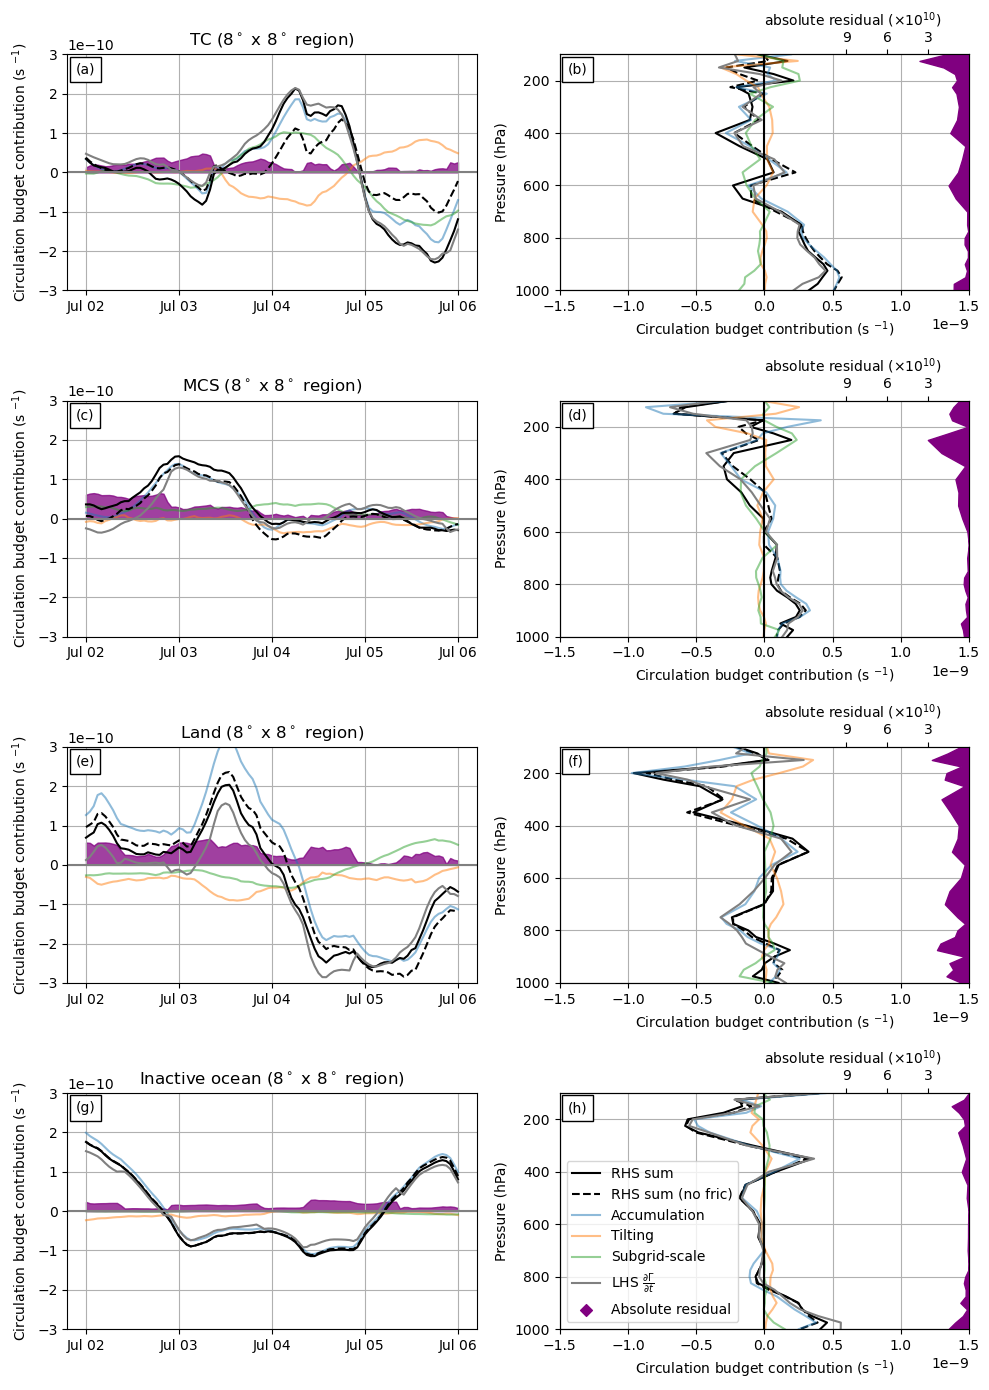

In [15]:
def plot_vertical_profile(tend, adv, tilt, fric, legend=False):

    levs = tend.level

    plt.plot(tilt + adv + fric, levs, color='k', linestyle='-', label='RHS sum')
    plt.plot(adv + tilt, levs, color='k', linestyle='--', label='RHS sum (no fric)')
    plt.plot(adv, levs, color='tab:blue', label='Accumulation', alpha=0.5)
    plt.plot(tilt, levs, color='tab:orange', label='Tilting', alpha=0.5)
    plt.plot(fric, levs, color='tab:green', label='Subgrid-scale', alpha=0.5)

    plt.plot(tend, levs, color='grey', label=r'LHS $\frac{\partial\Gamma}{\partial t}$')
    # plt.plot(res_nofric_A, levs, color='k', linestyle=':', label='residual (no fric)')
    # fake scatter plot for legend
    plt.scatter(1000, 1000, marker='D', color='purple', label='Absolute residual')

    plt.ylim(100, 1000)
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('Circulation budget contribution (s $^{-1})$')
    plt.xlim(-1.5e-9, 1.5e-9)
    plt.grid()
    plt.axvline(c='k')

    if legend:
        plt.legend()
    

    ax2 = plt.gca().twiny()
    #ax2.stackplot(abs(tend - (tilt + adv + fric)), levs, color='purple')
    #ax2.plot(abs(tend - (tilt + adv + fric)), levs, color='purple')
    ax2.fill_betweenx(levs, 0, abs(tend - (tilt + adv + fric))*1e10, color='purple')
    ax2.set_xlim(30, 0)
    ax2.set_xticks(np.arange(9, 0, -3))
    ax2.set_xlabel(r'absolute residual ($\times 10^{10}$)', ha='left')



def plot_timeseries(dav_dt_smooth, flux_div_smooth, tilt_smooth, fric_smooth):
    # Time stuff
    # remove points at end due to 24-point smoothing
    times = pd.to_datetime(dav_dt_smooth.time.values)#[-5:6]#[(n_av/2-1):(-n_av/2)]#[11:-12]
    plot_times = times.strftime('%b %d')# %H')
    t = dav_dt_smooth.time#adv_A.time[-5:6]
    
    plt.plot(t, flux_div_smooth.sel(level=700), label = 'Accumulation', color = 'tab:blue', alpha=0.5)
    plt.plot(t, tilt_smooth.sel(level=700), label = 'Tilting', color = 'tab:orange', alpha=0.5)
    
    t2 = fric_smooth.time#[-5:6]#[11:-12]
    plt.plot(t2, fric_smooth.sel(level=700), label = 'Friction', color = 'tab:green', alpha=0.5)
        
    plt.plot(t, flux_div_smooth.sel(level=700) + tilt_smooth.sel(level=700), label = 'RHS sum (no fric)', color = 'k', linestyle='--')
    plt.plot(t2, flux_div_smooth.sel(level=700) + tilt_smooth.sel(level=700) + fric_smooth.sel(level=700), label='RHS sum', color='k')
    plt.plot(t, dav_dt_smooth.sel(level=700), label=r'LHS $\frac{\partial\Gamma}{\partial t}$', color = 'grey')

    plt.fill_between(t, 0, abs(dav_dt_smooth - (flux_div_smooth + tilt_smooth + fric_smooth)).sel(level=700), color='purple', alpha=0.75)
    
    plt.axhline(color = 'grey')
    plt.ylabel('Circulation budget contribution (s $^{-1})$')
    #plt.ylim((-2e-10,2e-10))
    plt.xticks(t.values[::24], plot_times[::24])
    plt.ylim(-3.0e-10, 3.0e-10)
    #plt.legend(loc='upper left')
    plt.grid()


plt.figure(figsize=(10, 14))

plt.subplot(421)
plot_timeseries(dav_dt_smooth_A, flux_div_smooth_A, tilt_smooth_A, fric_smooth_A)
plt.text(0.02, 0.92, '(a)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('TC (8$^\circ$ x 8$^\circ$ region)')

plt.subplot(422)
plot_vertical_profile(dav_dt_cs_A, flux_div_cs_A, tilt_cs_A, fric_cs_A)
plt.text(0.02, 0.92, '(b)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.subplot(423)
plot_timeseries(dav_dt_smooth_B, flux_div_smooth_B, tilt_smooth_B, fric_smooth_B)
plt.text(0.02, 0.92, '(c)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('MCS (8$^\circ$ x 8$^\circ$ region)')

plt.subplot(424)
plot_vertical_profile(dav_dt_cs_B, flux_div_cs_B, tilt_cs_B, fric_cs_B)
plt.text(0.02, 0.92, '(d)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.subplot(425)
plot_timeseries(dav_dt_smooth_C, flux_div_smooth_C, tilt_smooth_C, fric_smooth_C)
plt.text(0.02, 0.92, '(e)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('Land (8$^\circ$ x 8$^\circ$ region)')

plt.subplot(426)
plot_vertical_profile(dav_dt_cs_C, flux_div_cs_C, tilt_cs_C, fric_cs_C)
plt.text(0.02, 0.92, '(f)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.subplot(427)
plot_timeseries(dav_dt_smooth_D, flux_div_smooth_D, tilt_smooth_D, fric_smooth_D)
plt.text(0.02, 0.92, '(g)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('Inactive ocean (8$^\circ$ x 8$^\circ$ region)')

plt.subplot(428)
plot_vertical_profile(dav_dt_cs_D, flux_div_cs_D, tilt_cs_D, fric_cs_D, legend=True)
plt.text(0.02, 0.92, '(h)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.tight_layout()


### Calculating the errors in the budget and plotting as Hovmollers (Figure 4)

In [16]:
# normalised column integrated mean absolute difference

def NCIMAD(res):
    return ((np.sqrt(res**2)).integrate('level') * (100/g) / (max_lev - min_lev)).mean('time').values


In [17]:
max_lev = res_A['level'][-1]
min_lev = res_A['level'][0]

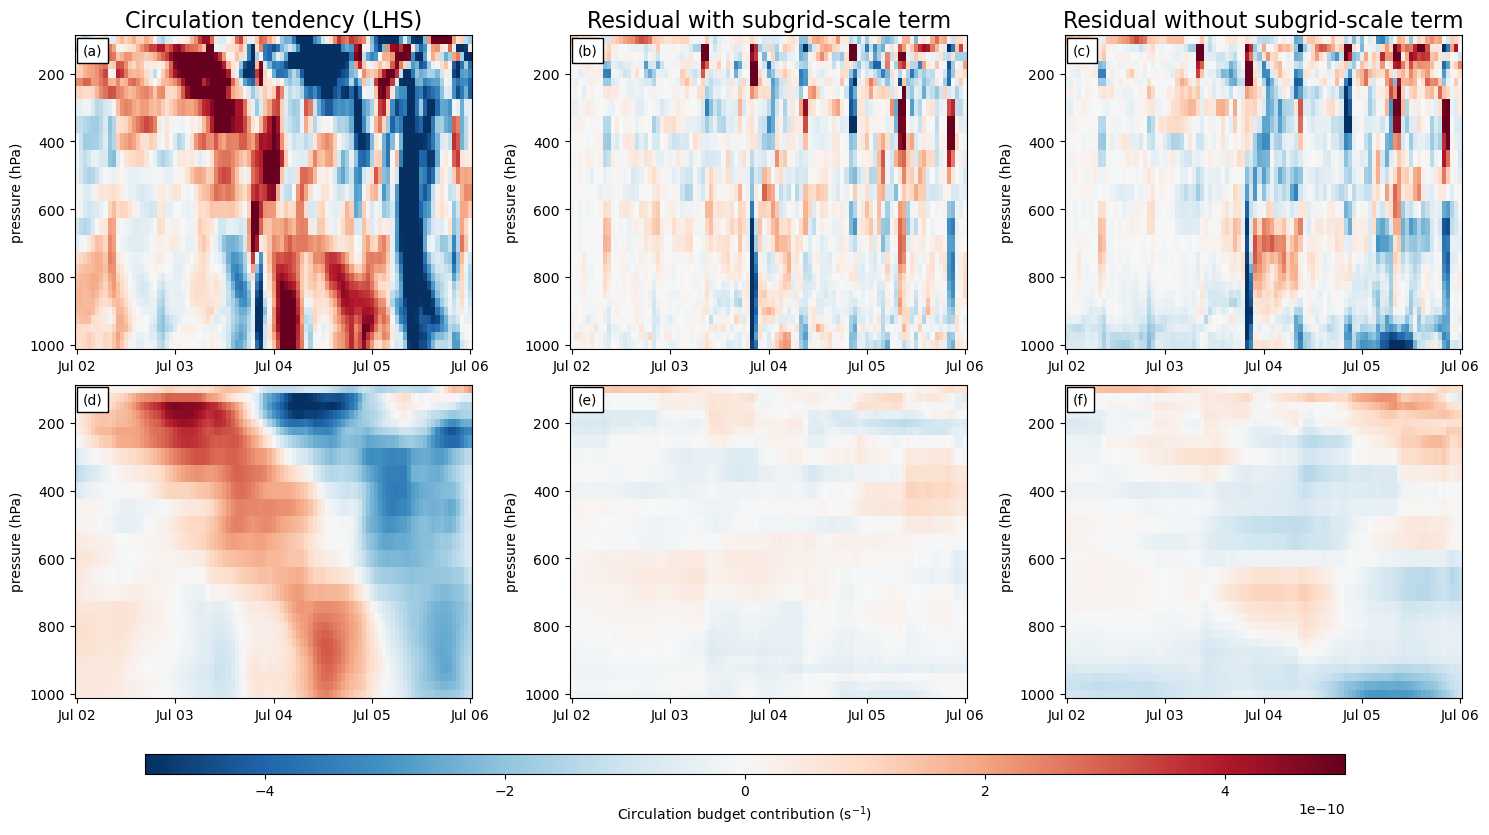

In [18]:
fig = plt.figure(figsize=(15, 8))

[times, levs] = np.meshgrid(res_smooth_A.time, res_smooth_A.level)

# remove points at end due to 24-point smoothing
times = pd.to_datetime(res_smooth_A.time.values)
plot_times = times.strftime('%b %d')

plt.subplot(231)
quad1 = plt.pcolormesh(times, levs, dav_dt_A[12:-11,:].T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(a)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('Circulation tendency (LHS)', fontsize=16)

plt.subplot(234)
quad2 = plt.pcolormesh(times, levs, dav_dt_smooth_A.T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(d)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.subplot(232)
quad1 = plt.pcolormesh(times, levs, res_fric_A[12:-11,:].T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(b)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('Residual with subgrid-scale term', fontsize=16)

plt.subplot(233)
quad2 = plt.pcolormesh(times, levs, res_A[12:-11,:].T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(c)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)
plt.title('Residual without subgrid-scale term', fontsize=16)

plt.subplot(235)
quad3 = plt.pcolormesh(times, levs, res_fric_smooth_A.T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_fric_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(e)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)

plt.subplot(236)
quad4 = plt.pcolormesh(times, levs, res_smooth_A.T, vmin=-5e-10, vmax=5e-10, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.ylabel('pressure (hPa)')
plt.xticks(res_smooth_A.time.values[::24], plot_times[::24])
plt.text(0.02, 0.94, '(f)', bbox={'fc': 'w'}, transform=plt.gca().transAxes)


plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

cb_ax = fig.add_axes([0.1, 0.025, 0.8, 0.025])
cb = fig.colorbar(quad1, cax=cb_ax, orientation='horizontal')
cb.set_label('Circulation budget contribution (s$^{-1}$)')